### 0. Import Libraries

In [1]:
# Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
import missingno as msno
from collections import defaultdict

# for filling state and city data
import zipcodes
from pprint import pprint


# for filling longitude and latitude data
import requests
import pandas as pd
import io
import csv

# checking similar names
from difflib import get_close_matches,SequenceMatcher
from IPython.display import display

### 1. Data Loading

In [18]:
# load dataset
food_dataset = pd.read_csv("Food_Inspections_20250216.csv")
food_dataset.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
0,1106427,BLOOMING BUD DAYCARE,BLOOMING BUD DAYCARE,2215789.0,Daycare Combo 1586,Risk 1 (High),5715 N LINCOLN AVE,CHICAGO,IL,60659.0,03/07/2013,License,Pass,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.985390,-87.698734,"(41.98538950526786, -87.69873407149943)"
1,2608378,Babas Halal,Babas Halal,2684170.0,Restaurant,Risk 1 (High),7901 S DAMEN AVE,CHICAGO,IL,60620.0,12/03/2024,Complaint,Fail,"1. PERSON IN CHARGE PRESENT, DEMONSTRATES KNOW...",41.750189,-87.672986,"(41.750189342293375, -87.67298583977204)"
2,1106406,FIRST ZABIHA MEAT BAZAAR,FIRST ZABIHA MEAT BAZAAR,2232559.0,Grocery Store,Risk 2 (Medium),2907 W DEVON AVE,CHICAGO,IL,60659.0,02/20/2013,License,Fail,"11. ADEQUATE NUMBER, CONVENIENT, ACCESSIBLE, D...",41.997401,-87.702385,"(41.99740137039031, -87.70238538227812)"
3,2609909,HAPPY MARKET,HAPPY MARKET,2912802.0,Grocery Store,Risk 2 (Medium),2334 S WENTWORTH AVE,CHICAGO,IL,60616.0,01/02/2025,Canvass,Pass w/ Conditions,2. CITY OF CHICAGO FOOD SERVICE SANITATION CER...,41.849954,-87.632094,"(41.84995400192252, -87.63209419559098)"
4,2609927,SAT KAIVAL FOOD INC/SUBWAY,SAT KAIVAL FOOD INC/SUBWAY,2728400.0,Restaurant,Risk 1 (High),1916 S STATE ST,CHICAGO,IL,60616.0,01/02/2025,Canvass,Pass,36. THERMOMETERS PROVIDED & ACCURATE - Comment...,41.856053,-87.627311,"(41.85605269621059, -87.62731125804903)"


In [19]:
# get the data type
food_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287237 entries, 0 to 287236
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Inspection ID    287237 non-null  int64  
 1   DBA Name         287237 non-null  object 
 2   AKA Name         284811 non-null  object 
 3   License #        287219 non-null  float64
 4   Facility Type    282040 non-null  object 
 5   Risk             287149 non-null  object 
 6   Address          287237 non-null  object 
 7   City             287073 non-null  object 
 8   State            287179 non-null  object 
 9   Zip              287198 non-null  float64
 10  Inspection Date  287237 non-null  object 
 11  Inspection Type  287236 non-null  object 
 12  Results          287237 non-null  object 
 13  Violations       207585 non-null  object 
 14  Latitude         286259 non-null  float64
 15  Longitude        286259 non-null  float64
 16  Location         286259 non-null  obje

In [20]:
# get basic statistical description
food_dataset.describe(include='all')

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
count,2.872370e+05,287237,284811,2.872190e+05,282040,287149,287237,287073,287179,287198.000000,287237,287236,287237,207585,286259.000000,286259.000000,286259
unique,NaN,33304,31703,NaN,519,4,30905,86,6,NaN,3813,110,7,206183,NaN,NaN,18493
top,NaN,SUBWAY,SUBWAY,NaN,Restaurant,Risk 1 (High),11601 W TOUHY AVE,CHICAGO,IL,NaN,11/14/2013,Canvass,Pass,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,NaN,NaN,"(42.00875076599798, -87.90687413400109)"
freq,NaN,3777,4646,NaN,193855,211761,3057,286102,287164,NaN,185,149444,148027,11,NaN,NaN,3587
mean,1.789447e+06,NaN,NaN,1.755947e+06,NaN,NaN,NaN,NaN,NaN,60628.660116,NaN,NaN,NaN,NaN,41.880779,-87.676337,NaN
std,7.283623e+05,NaN,NaN,9.352139e+05,NaN,NaN,NaN,NaN,NaN,155.440967,NaN,NaN,NaN,NaN,0.080997,0.058353,NaN
min,4.424700e+04,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,10014.000000,NaN,NaN,NaN,NaN,41.644670,-87.906874,NaN
25%,1.327178e+06,NaN,NaN,1.379974e+06,NaN,NaN,NaN,NaN,NaN,60614.000000,NaN,NaN,NaN,NaN,41.832354,-87.707427,NaN
50%,1.981286e+06,NaN,NaN,2.069431e+06,NaN,NaN,NaN,NaN,NaN,60625.000000,NaN,NaN,NaN,NaN,41.891814,-87.666344,NaN
75%,2.472778e+06,NaN,NaN,2.411182e+06,NaN,NaN,NaN,NaN,NaN,60643.000000,NaN,NaN,NaN,NaN,41.939768,-87.634868,NaN


In [21]:
# count number of missing values
food_dataset.isnull().sum()

Inspection ID          0
DBA Name               0
AKA Name            2426
License #             18
Facility Type       5197
Risk                  88
Address                0
City                 164
State                 58
Zip                   39
Inspection Date        0
Inspection Type        1
Results                0
Violations         79652
Latitude             978
Longitude            978
Location             978
dtype: int64

In [22]:
food_dataset.columns

Index(['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Facility Type',
       'Risk', 'Address', 'City', 'State', 'Zip', 'Inspection Date',
       'Inspection Type', 'Results', 'Violations', 'Latitude', 'Longitude',
       'Location'],
      dtype='object')

#### Insight:
- DBA Name and AKA Name are pretty similar in terms of word content. We need to confirm if AKA Name is subset of DBA Name.
- License # should have data type integer because it's presented in whole numbers.
- Zip should have data type string (it's a categorical identifier) with 5 digits in US.

### 2. Data Transformation
1. Column name format
2. Change data type of License to string. It's only a unique identifier, should be a whole number.
2. Reformat the Zip data type into string with 5 digits, following US format.
3. Fillthe State, and City columns based on Zip data
4. Risk column content transformation: create new columns (risk_level, inspection_frequency)

#### i. Column Names
- **goal**: change the column name format into lowercase, space in between to _, and remove special characters ("#")
- **reason**: it's more convenient when accessing the data on database.

In [23]:
# Column name changer function
def col_name_changer(df):
    # 1. Change to lower case
    df.columns = df.columns.str.lower()
    # 2. Change space to _
    df.columns = df.columns.str.replace(" ","_")
    # 3. Remove special characters: change # on License # to "num"
    df.columns = df.columns.str.replace("#",'num')
    # 4. Perform strip to ensure no extra white spaces
    df.columns = df.columns.str.strip()
    return df

In [24]:
# Copy dataset
updated_food_dataset = food_dataset.copy()
# Apply function
updated_food_dataset = col_name_changer(updated_food_dataset)

# Show result
updated_food_dataset.columns

Index(['inspection_id', 'dba_name', 'aka_name', 'license_num', 'facility_type',
       'risk', 'address', 'city', 'state', 'zip', 'inspection_date',
       'inspection_type', 'results', 'violations', 'latitude', 'longitude',
       'location'],
      dtype='object')

##### Insight:
- successful transformation

#### ii. License Number Column

In [ ]:
# function to process license numbers
def process_license_numbers(df, license_col='license_num'):
    """
    Safely converts license numbers to strings and cleans formatting.

    Returns:
        DataFrame with processed license numbers
        Dictionary of processing statistics
    """
    # Create a copy
    df = df.copy()
    stats = {
        'initial_null_count': df[license_col].isna().sum(),
        'initial_dtype': str(df[license_col].dtype)
    }
    
    try:
        # Convert to string, handling nulls and floats
        df[license_col] = (
            df[license_col]
            .astype('string')
            .str.replace(r'\.0$', '', regex=True)  # Remove trailing .0 from floats
            .str.strip()  # Remove whitespace
            .replace('nan', pd.NA)  # Restore actual nulls
        )
        
        # Validation stats
        stats.update({
            'final_null_count': df[license_col].isna().sum(),
            'final_dtype': str(df[license_col].dtype),
            'sample_values': df[license_col].dropna().sample(3).tolist()
        })
        
    except Exception as e:
        stats['error'] = f"Processing failed: {str(e)}"
        raise ValueError(f"License number processing error: {e}") from e
    
    return df


In [26]:
# Safely convert float license numbers to strings
updated_food_dataset = process_license_numbers(updated_food_dataset)

# show result
updated_food_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287237 entries, 0 to 287236
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   inspection_id    287237 non-null  int64  
 1   dba_name         287237 non-null  object 
 2   aka_name         284811 non-null  object 
 3   license_num      287219 non-null  string 
 4   facility_type    282040 non-null  object 
 5   risk             287149 non-null  object 
 6   address          287237 non-null  object 
 7   city             287073 non-null  object 
 8   state            287179 non-null  object 
 9   zip              287198 non-null  float64
 10  inspection_date  287237 non-null  object 
 11  inspection_type  287236 non-null  object 
 12  results          287237 non-null  object 
 13  violations       207585 non-null  object 
 14  latitude         286259 non-null  float64
 15  longitude        286259 non-null  float64
 16  location         286259 non-null  obje

#### iii. Zip Column
1. Convert zip from float to string form
2. Identify if the data stored are consistent

##### 1. Apply cleaning function on zip

In [27]:
# define the zip data cleaning function
def clean_zip_data(df, zip_col='zip'):
    """
    Enhanced ZIP code cleaner that:
    1. Handles floats/integers (e.g., 60601.0 → "60601")
    2. Preserves leading zeros (e.g., "07001" → "07001")
    3. Removes ZIP+4 extensions (e.g., "60601-1234" → "60601")
    4. Flags invalid ZIPs (non-numeric, wrong length)
    5. Compatible with the `zipcodes` package
    
    Returns:
        DataFrame with:
        - Original column (renamed to zip_raw)
        - Cleaned column (zip_clean)
        - Validation flag (zip_valid)
    """
    df = df.copy()
    
    # Convert to string and clean
    df['zip_clean'] = (
        df[zip_col]
        .astype(str)
        .str.strip()
        .str.replace(r'\.0$', '', regex=True)  # Remove .0 from floats
        .str.extract(r'(\d{5})')[0]            # Extract first 5 digits only
    )
    
    # Standardize to 5-digit strings
    df['zip_clean'] = (
        df['zip_clean']
        .str.zfill(5)                          # Pad with leading zeros
        .where(df['zip_clean'].str.len() == 5)  # Only keep 5-digit codes
        .replace('00000', np.nan)              # Handle all-zero cases
    )
    
    # Validation (matches USPS 5-digit format)
    df['zip_valid'] = (
        df['zip_clean']
        .notna()
        .astype('boolean')
    )
    df['zip_clean'] = df['zip_clean'].astype('string')  # Pandas' StringDtype    
    return df

##### 2. Implement to whole dataset
- Remove zip_valid flag and replace previous zip value with the cleaned version

In [28]:
# implement on dataset
updated_food_dataset = clean_zip_data(updated_food_dataset)
# removal
updated_food_dataset = updated_food_dataset.drop(columns=['zip'],axis=1)
# change name
updated_food_dataset = updated_food_dataset.rename(columns={'zip_clean':'zip'})


In [29]:
# show result
updated_food_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287237 entries, 0 to 287236
Data columns (total 18 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   inspection_id    287237 non-null  int64  
 1   dba_name         287237 non-null  object 
 2   aka_name         284811 non-null  object 
 3   license_num      287219 non-null  string 
 4   facility_type    282040 non-null  object 
 5   risk             287149 non-null  object 
 6   address          287237 non-null  object 
 7   city             287073 non-null  object 
 8   state            287179 non-null  object 
 9   inspection_date  287237 non-null  object 
 10  inspection_type  287236 non-null  object 
 11  results          287237 non-null  object 
 12  violations       207585 non-null  object 
 13  latitude         286259 non-null  float64
 14  longitude        286259 non-null  float64
 15  location         286259 non-null  object 
 16  zip              287198 non-null  stri

In [30]:
# show result
updated_food_dataset.isnull().sum()

inspection_id          0
dba_name               0
aka_name            2426
license_num           18
facility_type       5197
risk                  88
address                0
city                 164
state                 58
inspection_date        0
inspection_type        1
results                0
violations         79652
latitude             978
longitude            978
location             978
zip                   39
zip_valid              0
dtype: int64

#### iv. State Column
- use zipcodes to fill the missing values in state.

##### 1. Apply zipcodes function to get state

In [31]:
# Prepare function to match the zip code with the zipcode database from zipcodes
def get_zip_info(zip_code, field='state'):
    """Get state/city from ZIP code with proper error handling.
    Args:
        zip_code: Input ZIP (str/int/float)
        field: 'state' or 'city'
    Returns:
        str or None
    """
    if pd.isna(zip_code):
        return None
    try:
        # Convert to string and pad with zeros
        zip_str = str(int(zip_code)).zfill(5) if str(zip_code).isdigit() else str(zip_code)
        matched = zipcodes.matching(zip_str)
        
        if not matched:
            return None
        return matched[0].get(field)  # access the needed field
    
    except Exception as e:
        print(f"Error processing ZIP {zip_code}: {str(e)}")
        return None    

##### 2. Implement on whole dataset

In [32]:
# apply to the whole dataset
updated_food_dataset['state'] = updated_food_dataset.apply(
    lambda row: row['state'] if pd.notna(row['state']) else get_zip_info(row['zip'],'state'), 
    axis=1
)

In [33]:
# show result
updated_food_dataset.isnull().sum()

inspection_id          0
dba_name               0
aka_name            2426
license_num           18
facility_type       5197
risk                  88
address                0
city                 164
state                  0
inspection_date        0
inspection_type        1
results                0
violations         79652
latitude             978
longitude            978
location             978
zip                   39
zip_valid              0
dtype: int64

###### Insight:
- All missing values in state column is sorted.

#### v. City Column
- implement the same function as State Column.

##### 1. Implement on full dataset

In [34]:
# apply to the whole dataset
updated_food_dataset['city'] = updated_food_dataset.apply(
    lambda row: row['city'] if pd.notna(row['city']) else get_zip_info(row['zip'],'city'), 
    axis=1
)

In [35]:
# check number of missing values
updated_food_dataset.isnull().sum()

inspection_id          0
dba_name               0
aka_name            2426
license_num           18
facility_type       5197
risk                  88
address                0
city                  36
state                  0
inspection_date        0
inspection_type        1
results                0
violations         79652
latitude             978
longitude            978
location             978
zip                   39
zip_valid              0
dtype: int64

#### vi. Latitude and Longitude Columns
- use GeoCoder Census data in 2010.
- you might need to run twice, first time it might error.

##### 1. Implement on whole dataset

In [36]:
# formatting address
def remove_nested_brackets(text):
    """Removes all content inside brackets, including nested brackets, using a stack-based approach."""
    if pd.isna(text):
        return text
    
    text = str(text)
    stack = []
    result = []
    
    for char in text:
        if char == '(':
            stack.append(len(result))
        elif char == ')' and stack:
            result = result[:stack.pop()]
        elif not stack:
            result.append(char)
    
    return ''.join(result)

def format_address(address):
    if pd.isna(address):
        return address
    
    # Step 1: Remove all nested brackets
    address = remove_nested_brackets(str(address))
    
    # Step 2: Normalize whitespace
    address = re.sub(r'\s+', ' ', address).strip()
    
    # Step 3: Convert to title case (except abbreviations)
    address = address.title()
    
    # Step 4: Fix common postal abbreviations
    abbreviations = {
        r'\bSt\b': 'ST',
        r'\bAve\b': 'AVE',
        r'\bBlvd\b': 'BLVD',
        r'\bDr\b': 'DR',
        r'\bLn\b': 'LN',
        r'\bRd\b': 'RD',
        r'\bHwy\b': 'HWY',
        r'\bUs\b': 'US',
    }
    for pattern, replacement in abbreviations.items():
        address = re.sub(pattern, replacement, address)
    
    return address

In [37]:
# Fill missing values
def geocode_missing_coordinates(df: pd.DataFrame) -> pd.DataFrame:
    """
    Geocode missing latitude/longitude data using Census API
    Follows exact workflow from your code example
    
    Parameters:
        df: DataFrame containing address components and missing coordinates
    
    Returns:
        DataFrame with updated latitude/longitude for previously missing rows
    """
    # --- 1. Prepare Missing Data ---
    # Get rows where coordinates are missing
    missing_mask = df['latitude'].isna() | df['longitude'].isna()
    missing_data = df[missing_mask][['address','city','state','latitude','longitude','location','zip']].copy()
    
    if len(missing_data) == 0:
        print("No missing coordinates to geocode")
        return df
    
    # Format addresses
    missing_data['address'] = missing_data['address'].apply(format_address)
    
    # --- 2. Prepare API Input ---
    geocoder_df = pd.DataFrame({
        'street': missing_data['address'],
        'city': missing_data['city'],
        'state': missing_data['state'],
        'zip': missing_data['zip']
    }).reset_index(drop=True)
    
    # Save to CSV
    with open('my_geocoder_input.csv', 'w', encoding='utf-8') as f:
        geocoder_df.to_csv(f, index=True, header=False)
    
    # --- 3. Call Census API ---
    url = 'https://geocoding.geo.census.gov/geocoder/geographies/addressbatch'
    try:
        with open('my_geocoder_input.csv', 'rb') as f:
            files = {'addressFile': ('my_geocoder_input.csv', f, 'text/csv')}
            payload = {
                'benchmark': 'Public_AR_Current',
                'vintage': 'Census2010_Current',
                'format': 'json'
            }
            response = requests.post(url, files=files, data=payload, timeout=30)
        
        if response.status_code != 200:
            raise Exception(f"API Error {response.status_code}: {response.text[:200]}")
            
        # Save raw response
        with open("geocoded_results.csv", "wb") as f:
            f.write(response.content)
            
    except Exception as e:
        print(f"Geocoding failed: {str(e)}")
        return df
    
    # --- 4. Process Results ---
    try:
        # Load and parse results
        result_df = pd.read_csv(
            'geocoded_results.csv',
            header=None,
            quotechar='"',
            names=[
                "ID", "input_address", "match_status", "match_type",
                "matched_address", "location", "tigerline_id", "side",
                "statefips", "countyfips", "tractcode", "blockcode"
            ]
        )
        
        # Filter successful matches
        matched = result_df[result_df['match_status'] == "Match"].copy()
        matched[['longitude', 'latitude']] = matched['location'].str.split(',', expand=True).astype(float)
        
    except Exception as e:
        print(f"Failed to process results: {str(e)}")
        return df
    
    # --- 5. Merge Results Back ---
    # Create matching keys
    missing_data['full_address'] = (
        missing_data['address'] + ', ' + 
        missing_data['city'] + ', ' + 
        missing_data['state'] + ', ' + 
        missing_data['zip'].astype(str)
    )
    
    # Create coordinate mapping
    coord_map = {
        row['input_address']: (row['latitude'], row['longitude'], row['location'])
        for _, row in matched.iterrows()
    }
    
    # Update coordinates in missing data
    missing_data['latitude'] = missing_data['full_address'].map(
        lambda x: coord_map.get(x, (None, None, None))[0]
    )
    missing_data['longitude'] = missing_data['full_address'].map(
        lambda x: coord_map.get(x, (None, None, None))[1]
    )
    missing_data['location'] = missing_data['full_address'].map(
        lambda x: coord_map.get(x, (None, None, None))[2]
    )
    
    # --- 6. Update Original DataFrame ---
    # Update only the rows that were missing coordinates
    df.update(missing_data[['latitude', 'longitude', 'location']])
    
    return df

In [38]:
# get the state before
updated_food_dataset.isnull().sum()

inspection_id          0
dba_name               0
aka_name            2426
license_num           18
facility_type       5197
risk                  88
address                0
city                  36
state                  0
inspection_date        0
inspection_type        1
results                0
violations         79652
latitude             978
longitude            978
location             978
zip                   39
zip_valid              0
dtype: int64

In [40]:
# apply on updated dataset
updated_food_dataset = geocode_missing_coordinates(updated_food_dataset)

In [41]:
# show total missing values after handling
updated_food_dataset.isnull().sum()

inspection_id          0
dba_name               0
aka_name            2426
license_num           18
facility_type       5197
risk                  88
address                0
city                  36
state                  0
inspection_date        0
inspection_type        1
results                0
violations         79652
latitude             171
longitude            171
location             171
zip                   39
zip_valid              0
dtype: int64

##### Insight:
- Cleaning was successful. Missing data reduced from 978 to 171.

#### vii. Risk Column

##### 1. Implement to whole dataset

In [42]:
# final function form
def risk_column_transformation(df):
    """
    Transforms the 'risk' column in-place, standardizing to:
    - 'High' (from 'Risk 1 (High)')
    - 'Medium' (from 'Risk 2 (Medium)')
    - 'Low' (from 'Risk 3 (Low)')
    - 'All' (for NaN or any other input)
    """
    # Strict mapping - only these exact inputs will convert
    allowed_mappings = {
        'Risk 1 (High)': 'High',
        'Risk 2 (Medium)': 'Medium',
        'Risk 3 (Low)': 'Low'
    }
    
    # Create a mask for values that need to be changed to 'All'
    to_replace = ~df['risk'].isin(allowed_mappings.keys()) | df['risk'].isna()
    
    # First map the allowed values
    df['risk'] = df['risk'].map(allowed_mappings)
    
    # Then replace everything else with 'All'
    df.loc[to_replace, 'risk'] = 'All'
    
    return df

In [43]:
# Implement change on the dataset
updated_food_dataset = risk_column_transformation(updated_food_dataset)

# Show result
updated_food_dataset.head()

,inspection_id,dba_name,aka_name,license_num,facility_type,risk,address,city,state,inspection_date,inspection_type,results,violations,latitude,longitude,location,zip,zip_valid
0,1106427,BLOOMING BUD DAYCARE,BLOOMING BUD DAYCARE,2215789,Daycare Combo 1586,High,5715 N LINCOLN AVE,CHICAGO,IL,03/07/2013,License,Pass,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.985390,-87.698734,"(41.98538950526786, -87.69873407149943)",60659,True
1,2608378,Babas Halal,Babas Halal,2684170,Restaurant,High,7901 S DAMEN AVE,CHICAGO,IL,12/03/2024,Complaint,Fail,"1. PERSON IN CHARGE PRESENT, DEMONSTRATES KNOW...",41.750189,-87.672986,"(41.750189342293375, -87.67298583977204)",60620,True
2,1106406,FIRST ZABIHA MEAT BAZAAR,FIRST ZABIHA MEAT BAZAAR,2232559,Grocery Store,Medium,2907 W DEVON AVE,CHICAGO,IL,02/20/2013,License,Fail,"11. ADEQUATE NUMBER, CONVENIENT, ACCESSIBLE, D...",41.997401,-87.702385,"(41.99740137039031, -87.70238538227812)",60659,True
3,2609909,HAPPY MARKET,HAPPY MARKET,2912802,Grocery Store,Medium,2334 S WENTWORTH AVE,CHICAGO,IL,01/02/2025,Canvass,Pass w/ Conditions,2. CITY OF CHICAGO FOOD SERVICE SANITATION CER...,41.849954,-87.632094,"(41.84995400192252, -87.63209419559098)",60616,True
4,2609927,SAT KAIVAL FOOD INC/SUBWAY,SAT KAIVAL FOOD INC/SUBWAY,2728400,Restaurant,High,1916 S STATE ST,CHICAGO,IL,01/02/2025,Canvass,Pass,36. THERMOMETERS PROVIDED & ACCURATE - Comment...,41.856053,-87.627311,"(41.85605269621059, -87.62731125804903)",60616,True


In [44]:
# show result
updated_food_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287237 entries, 0 to 287236
Data columns (total 18 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   inspection_id    287237 non-null  int64  
 1   dba_name         287237 non-null  object 
 2   aka_name         284811 non-null  object 
 3   license_num      287219 non-null  string 
 4   facility_type    282040 non-null  object 
 5   risk             287237 non-null  object 
 6   address          287237 non-null  object 
 7   city             287201 non-null  object 
 8   state            287237 non-null  object 
 9   inspection_date  287237 non-null  object 
 10  inspection_type  287236 non-null  object 
 11  results          287237 non-null  object 
 12  violations       207585 non-null  object 
 13  latitude         287066 non-null  float64
 14  longitude        287066 non-null  float64
 15  location         287066 non-null  object 
 16  zip              287198 non-null  stri

In [ ]:
# show total missing data
updated_food_dataset.isnull().sum()

inspection_id          0
dba_name               0
aka_name            2426
license_num           18
facility_type       5197
risk                   0
address                0
city                  36
state                  0
inspection_date        0
inspection_type        1
results                0
violations         79652
latitude             171
longitude            171
location             171
zip                   39
zip_valid              0
dtype: int64

##### Insight:
- conversion is successful

#### viii. aka_name Column

##### 1. Check similarity

In [46]:
# format the text for both dba_name and aka_name
def standardize_name_columns(df, dba_col='dba_name', aka_col='aka_name'):
    """
    Standardizes text format for name columns by:
    - Converting to lowercase
    - Stripping leading/trailing whitespace
    - Handling NaN values
    
    Parameters:
        df: Input DataFrame
        dba_col: Name of formal business name column (default 'dba_name')
        aka_col: Name of alternate name column (default 'aka_name')
    
    Returns:
        DataFrame with standardized name columns
    """
    # Create a copy to avoid SettingWithCopyWarning
    df = df.copy()
    
    # Standardize dba_name
    if dba_col in df.columns:
        df[dba_col] = (
            df[dba_col]
            .astype(str)  # Convert all to string first
            .str.lower()  # Convert to lowercase
            .str.strip()  # Remove whitespace
            .replace('nan', pd.NA)  # Restore actual NaN values
        )
    
    # Standardize aka_name
    if aka_col in df.columns:
        df[aka_col] = (
            df[aka_col]
            .astype(str)
            .str.lower()
            .str.strip()
            .replace('nan', pd.NA)
        )
    
    return df

In [47]:
# check similarity
def check_name_similarity(df, dba_col='dba_name', aka_col='aka_name', 
                        similarity_threshold=0.8, fill_missing=True):
    """
    Analyzes similarity between two name columns and optionally fills missing values.
    
    Parameters:
    - df: DataFrame containing the columns
    - dba_col: Formal name column (default 'dba_name')
    - aka_col: Alternate name column (default 'aka_name')
    - similarity_threshold: Score above which names are considered similar (0-1)
    - fill_missing: Whether to fill missing aka_names with dba_names (default True)
    
    Returns:
    - DataFrame with similarity analysis and optionally filled values
    - Similarity statistics
    """
    
    # Create working copy
    df = df.copy()
    
    # 1. Handle missing values
    missing_mask = df[aka_col].isna()
    if fill_missing:
        df.loc[missing_mask, aka_col] = df.loc[missing_mask, dba_col]
    
    # 2. Calculate similarity metrics
    def get_similarity(a, b):
        if pd.isna(a) or pd.isna(b):
            return 0
        return SequenceMatcher(None, str(a).lower(), str(b).lower()).ratio()
    
    df['name_similarity'] = df.apply(
        lambda x: get_similarity(x[dba_col], x[aka_col]), axis=1
    )
    
    # 3. Categorize relationships
    conditions = [
        df[aka_col].isna(),
        df[dba_col] == df[aka_col],
        df['name_similarity'] >= similarity_threshold,
        df['name_similarity'] > 0
    ]
    choices = [
        'missing',
        'exact_match',
        'similar',
        'different'
    ]
    df['name_relationship'] = pd.cut(
        df['name_similarity'],
        bins=[-1, 0, 0.1, similarity_threshold, 1],
        labels=['missing', 'different', 'some_similarity', 'similar']
    )
    
    # 4. Generate statistics
    stats = {
        'missing_initial': missing_mask.sum(),
        'missing_filled': fill_missing * missing_mask.sum(),
        'exact_matches': (df[dba_col] == df[aka_col]).sum(),
        'similar_count': (df['name_similarity'] >= similarity_threshold).sum(),
        'avg_similarity': df['name_similarity'].mean()
    }
    
    return df, stats

In [48]:
# display
def display_similarity_stats(stats):
    """
    Displays the similarity statistics in a simple DataFrame format.
    
    Parameters:
        stats (dict): Dictionary containing the similarity statistics
    """
    # Convert stats to DataFrame and format
    stats_df = pd.DataFrame.from_dict(stats, orient='index', columns=['Value'])
    
    # Format numeric values
    stats_df['Value'] = stats_df['Value'].apply(
        lambda x: f"{x:,.0f}" if isinstance(x, (int, float)) and x == int(x) 
        else f"{x:,.2f}" if isinstance(x, float) 
        else x
    )
    
    # Add description for each metric
    descriptions = {
        'missing_initial': 'Initial missing aka_name values',
        'missing_filled': 'aka_name values filled with dba_name',
        'exact_matches': 'Exact matches between names',
        'similar_count': 'Similar names (above threshold)',
        'avg_similarity': 'Average similarity score'
    }
    
    stats_df['Description'] = stats_df.index.map(descriptions)
    stats_df = stats_df[['Description', 'Value']]  # Reorder columns
    
    # Display with basic formatting
    print("Name Similarity Statistics")
    print("=" * 40)
    display(stats_df)
    print("=" * 40)


In [49]:
# apply on dataset
updated_food_dataset = standardize_name_columns(updated_food_dataset)

# Usage with your existing code
df_with_similarity, stats = check_name_similarity(
    updated_food_dataset,
    similarity_threshold=0.7,
    fill_missing=True
)

# Display the statistics
display_similarity_stats(stats)


Name Similarity Statistics


,Description,Value
missing_initial,Initial missing aka_name values,"2,426"
missing_filled,aka_name values filled with dba_name,"2,426"
exact_matches,Exact matches between names,"211,890"
similar_count,Similar names (above threshold),"248,128"
avg_similarity,Average similarity score,0.90


##### 2. Implement missing value imputation with dba_name

In [50]:
# fill null value implementation
updated_food_dataset['aka_name'] = updated_food_dataset['aka_name'].fillna(updated_food_dataset['dba_name'])

In [51]:
# show total missing values
updated_food_dataset.isnull().sum()

inspection_id          0
dba_name               0
aka_name               0
license_num           18
facility_type       5197
risk                   0
address                0
city                  36
state                  0
inspection_date        0
inspection_type        1
results                0
violations         79652
latitude             171
longitude            171
location             171
zip                   39
zip_valid              0
dtype: int64

### 3. Exploratory Data Analysis
- Profiling after data transformation

#### 1. Profiling Risk
- There are 4 risk categories: High, Medium, Low, and All.
- The category All is unknown, we cannot find description on metadata.

In [52]:
# profile risk
def profile_risk_column(df, risk_col='risk'):
    """
    Profiles a risk column with 'High', 'Medium', 'Low', and 'All' categories
    using the Set3 color palette without warnings.
    """
    # Create a clean copy and handle missing values
    df_clean = df.copy()
    df_clean[risk_col] = df_clean[risk_col].fillna('All')
    
    # Define allowed categories and Set3 colors
    valid_categories = ['High', 'Medium', 'Low', 'All']
    set3_colors = sns.color_palette("Set3", len(valid_categories)).as_hex()  # Convert to hex list
    
    # Initialize profile results
    profile = {
        'value_counts': None,
        'invalid_values': None,
        'pre_missing_count': df[risk_col].isna().sum()
    }
    
    # Value counts with percentages
    value_counts = df_clean[risk_col].value_counts()
    percentages = df_clean[risk_col].value_counts(normalize=True) * 100
    profile['value_counts'] = pd.DataFrame({
        'Count': value_counts,
        'Percentage': percentages.round(2)
    }).reindex(valid_categories)
    
    # Data quality checks
    invalid_mask = ~df_clean[risk_col].isin(valid_categories)
    profile['invalid_values'] = df_clean.loc[invalid_mask, risk_col].unique()
    profile['invalid_count'] = invalid_mask.sum()
    
    # Visualization with Set3 palette
    plt.figure(figsize=(14, 6))
    
    # 1. Count plot (corrected to avoid warnings)
    plt.subplot(1, 2, 1)
    ax = sns.countplot(
        x=risk_col, 
        data=df_clean, 
        order=valid_categories,
        hue=risk_col,  # Added to fix warning
        palette=set3_colors,
        legend=False   # Added to avoid duplicate legend
    )
    plt.title('Risk Level Distribution (Missing → All)', pad=20)
    
    # Add percentage labels
    total = len(df_clean)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2., height + 0.01*total,
                f'{height/total:.1%}',
                ha='center', fontsize=10)
    
    # 2. Pie chart
    plt.subplot(1, 2, 2)
    df_clean[risk_col].value_counts().reindex(valid_categories).plot.pie(
        autopct='%1.1f%%',
        colors=set3_colors,
        startangle=90,
        textprops={'fontsize': 12}
    )
    plt.title('Risk Level Proportion', pad=20)
    plt.ylabel('')
    
    plt.tight_layout()
    plt.show()
    
    return profile

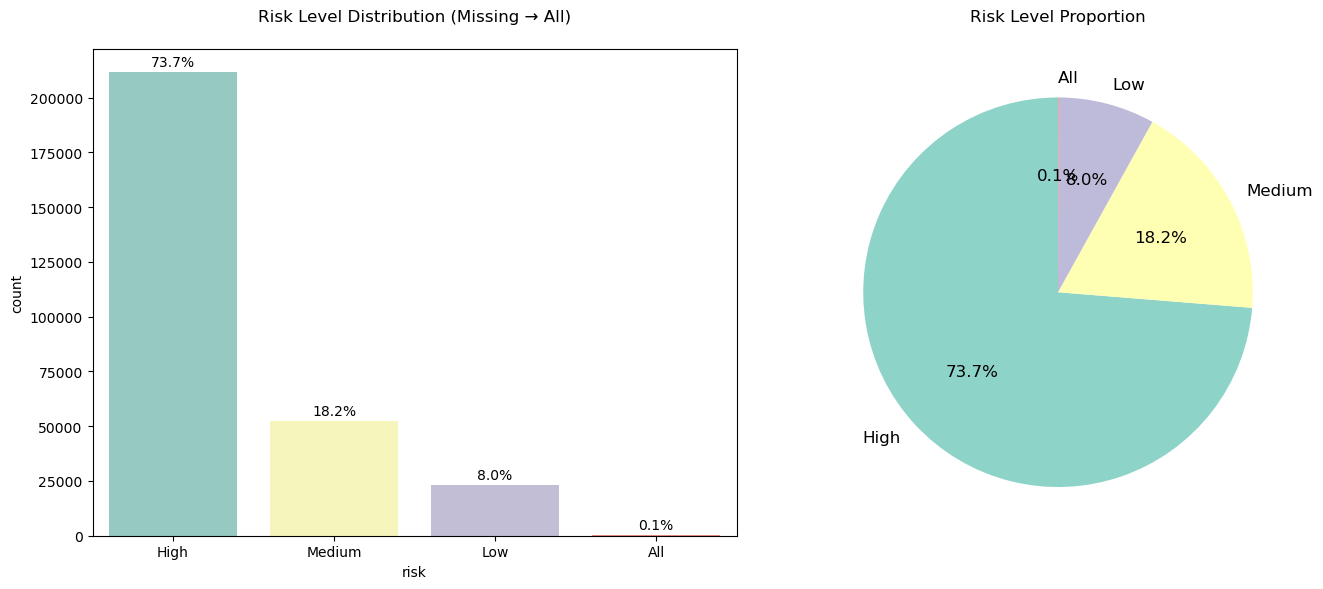

=== VALUE COUNTS ===
         Count  Percentage
risk                      
High    211761       73.72
Medium   52347       18.22
Low      22973        8.00
All        156        0.05

=== DATA QUALITY ===
Original missing values: 0
Invalid entries: 0


In [53]:
# print result
risk_profile = profile_risk_column(updated_food_dataset)
print("=== VALUE COUNTS ===")
print(risk_profile['value_counts'])
print(f"\n=== DATA QUALITY ===")
print(f"Original missing values: {risk_profile['pre_missing_count']}")
print(f"Invalid entries: {risk_profile['invalid_count']}")

##### Insight:
1. The alignment of the values are confirmed.
- Risk level = High means dangerous to public.
- Risk level = Medium means quite dangerous to public
- Risk level = Low means the case is not severe.
2. The inspection data suggested a major proportion of establishments has **high inspection frequency**.

#### 2. Profiling Zip
- check most frequent zip codes appearing in the dataset
- zip length analysis validation

In [55]:
# Check any outlier possibility within the dataset
def summarize_zip_distribution(df, zip_col='zip'):
    """
    Profiles ZIP code distribution by prefix:
    - Chicago (606xx)
    - Potential IL Suburbs (600xx-604xx)
    - Other ZIPs (non-60xxx)
    """
    # Clean ZIPs (drop NA, convert to string, strip whitespace)
    clean_zips = df[zip_col].dropna().astype(str).str.strip()
    
    # Classify ZIPs by prefix
    is_chicago = clean_zips.str.startswith('606')
    is_potential_suburb = (
        clean_zips.str.startswith('60') &  # Starts with 60
        ~clean_zips.str.startswith('606')   # Exclude Chicago
    )
    is_other = ~(is_chicago | is_potential_suburb)
    
    # Generate summary
    summary = pd.DataFrame({
        'Region': ['Chicago (606xx)', 'Potential IL Suburbs (600xx-604xx)', 'Other'],
        'Zip_Count': [is_chicago.sum(), is_potential_suburb.sum(), is_other.sum()],
        'Zip_Examples': [
            ', '.join(clean_zips[is_chicago].unique()[:3]),
            ', '.join(clean_zips[is_potential_suburb].unique()[:3]),
            ', '.join(clean_zips[is_other].unique()[:3])
        ]
    })
    
    return summary

In [56]:
# Usage
zip_distribution = summarize_zip_distribution(updated_food_dataset)
print(zip_distribution)

                               Region  Zip_Count         Zip_Examples
0                     Chicago (606xx)     285048  60659, 60620, 60616
1  Potential IL Suburbs (600xx-604xx)       2135  60707, 60827, 60513
2                               Other         15  80439, 90067, 46410


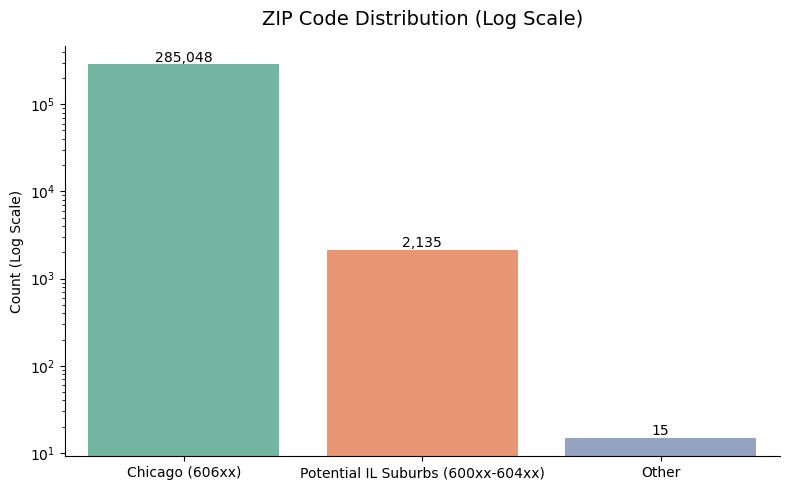

In [57]:
# Plot to show difference
plt.figure(figsize=(8, 5))
ax = sns.barplot(x='Region', y='Zip_Count', data=zip_distribution, hue
                 ='Region',legend=False,palette='Set2')

# Log scale for y-axis
ax.set_yscale('log')  # Critical for visibility of small counts
plt.title('ZIP Code Distribution (Log Scale)', fontsize=14, pad=15)
plt.ylabel('Count (Log Scale)')
plt.xlabel('')

# Add exact counts as labels
for p in ax.patches:
    ax.annotate(
        f"{int(p.get_height()):,}", 
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center', xytext=(0, 5), textcoords='offset points'
    )

sns.despine()
plt.tight_layout()
plt.show()


In [62]:
# Get and print only the ZIP codes (no DataFrame)
non_60_zips = updated_food_dataset['zip'].dropna().astype(str).str.strip()
non_60_zips = non_60_zips[~non_60_zips.str.startswith('60')]

print("Non-60 ZIP Codes:")
for zip_code in sorted(non_60_zips):
    print(zip_code)

Non-60 ZIP Codes:
10014
46319
46322
46394
46410
46410
46410
46410
46410
46410
46410
53061
80439
90067
90504


Text(0.5, 1.0, 'ZIP Code Length Distribution')

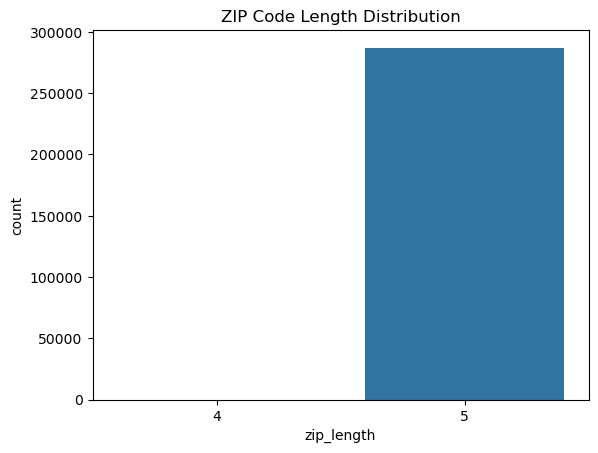

In [89]:
# ensure zip length consistent
consistent_zip_length = updated_food_dataset.copy()
consistent_zip_length['zip_length'] = consistent_zip_length['zip'].astype(str).str.len()
sns.countplot(data=consistent_zip_length, x='zip_length')
plt.title("ZIP Code Length Distribution")

#### 3. Profiling State

In [58]:
# show the table
state_profile = (
    updated_food_dataset['state']
    .value_counts(dropna=False)
    .rename("Count")
    .to_frame()
    .assign(Percentage=lambda x: (x['Count'] / len(updated_food_dataset)).round(2))
    .rename_axis('State')
    .reset_index()
)
display(state_profile)

,State,Count,Percentage
0,IL,287222,1.0
1,IN,10,0.0
2,CA,2,0.0
3,CO,1,0.0
4,NY,1,0.0
5,WI,1,0.0


##### Insight:
- While most data was originated from IL, there were also a few data coming from other states (IN, CA, CO,NY, and WI).

#### 4. Profiling State, Zip, City Consistency

In [59]:
# Find ZIPs mapped to multiple states (invalid)
zip_state_violations = updated_food_dataset.groupby('zip')['state'].nunique()
anomalous_zips = zip_state_violations[zip_state_violations > 1]
print(f"ZIPs with conflicting states: {len(anomalous_zips)}")

# Show examples
display(updated_food_dataset[updated_food_dataset['zip'].isin(anomalous_zips.index)]
        .sort_values('zip')[['zip', 'state', 'city']].head(10))

ZIPs with conflicting states: 0


,zip,state,city


##### Insight:
- no invalid known zip data which mapped to multiple states

#### 5. Checking City and State Spelling Variations

In [60]:
sample_cities = updated_food_dataset['city'].dropna().unique()
for city in sample_cities[:5]:  # Check first 5 for demo
    matches = get_close_matches(city, sample_cities, n=5, cutoff=0.8)
    if len(matches) > 1:
        print(f"Potential duplicates for '{city}': {matches}")

Potential duplicates for 'CHICAGO': ['CHICAGO', 'CHICAGOO', 'CHICAGOI', 'CHICAGOC', 'CHICAGO.']
Potential duplicates for 'chicago': ['chicago', 'Chicago']
Potential duplicates for 'Chicago': ['Chicago', 'chicago', 'CHicago']
Potential duplicates for 'CHICAGO.': ['CHICAGO.', 'CHICAGO', 'CHICAGOO', 'CHICAGOI', 'CHICAGOC']


In [61]:
sample_states = updated_food_dataset['state'].dropna().unique()
for state in sample_states[:5]:  # Check first 5 for demo
    matches = get_close_matches(city, sample_states, n=5, cutoff=0.8)
    if len(matches) > 1:
        print(f"Potential duplicates for '{state}': {matches}")

##### Insight:
- there are misspellings for city column.

#### 6.Profiling inspection_date
- has no missing data problems

In [64]:
# Inspection date profiling
def profile_inspection_date(df):
    """Profiles the inspection_date column with temporal analysis"""
    # Convert to datetime and extract features
    df['inspection_date'] = pd.to_datetime(df['inspection_date'])
    df['inspection_year'] = df['inspection_date'].dt.year
    df['inspection_month'] = df['inspection_date'].dt.month_name()
    
    # Plot temporal distribution
    plt.figure(figsize=(15, 5))
    
    # Yearly trend
    plt.subplot(1, 2, 1)
    yearly_counts = df['inspection_year'].value_counts().sort_index()
    sns.lineplot(x=yearly_counts.index, y=yearly_counts.values)
    plt.title('Inspections by Year')
    plt.xlabel('Year')
    plt.ylabel('Count')
    
    # Monthly distribution
    plt.subplot(1, 2, 2)
    month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
                   'July', 'August', 'September', 'October', 'November', 'December']
    monthly_counts = df['inspection_month'].value_counts().reindex(month_order)
    sns.barplot(x=monthly_counts.index, y=monthly_counts.values)
    plt.title('Inspections by Month')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Date statistics
    print(f"Date Range: {df['inspection_date'].min().date()} to {df['inspection_date'].max().date()}")
    print(f"Most Active Year: {yearly_counts.idxmax()} ({yearly_counts.max():,} inspections)")
    print(f"Most Active Month: {monthly_counts.idxmax()} ({monthly_counts.max():,} inspections)")

=== INSPECTION DATE PROFILE ===


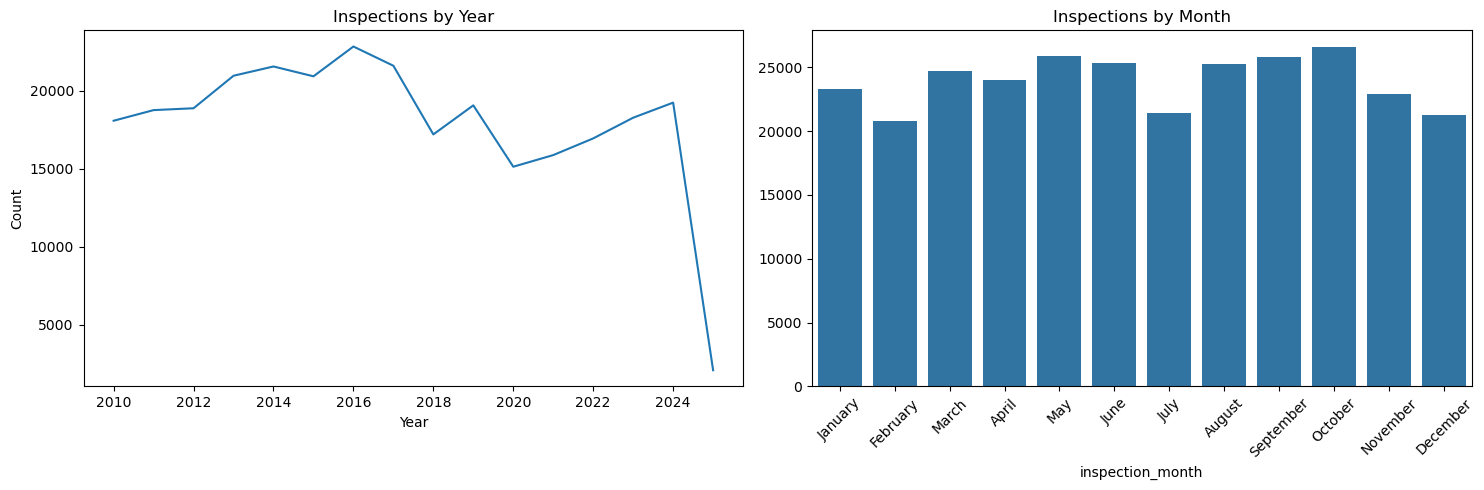

Date Range: 2010-01-04 to 2025-02-14
Most Active Year: 2016 (22,818 inspections)
Most Active Month: October (26,556 inspections)


In [65]:
# Run all profiles
print("=== INSPECTION DATE PROFILE ===")
profile_inspection_date(updated_food_dataset)

#### 7. Profiling Inspection Type
- Based on the metadata, there are 6 categories for inspection type: canvass, consultation, complaint, license, suspect food poisoning, and task-force inspection.
- It is possible for implementing reinspection.
- standardize_inspection_types function converts the inspection types categories into the main 6 categories.

In [66]:
# standardize inspection_type options
def standardize_inspection_types(df):
    """
    Standardizes inspection types into 6 official categories with re-inspection flags:
    ['canvass', 'consultation', 'complaint', 'license', 
     'suspect food poisoning', 'task-force inspection']
    Preserves re-inspection status when present.
    """
    # Primary category mapping with regex patterns
    category_map = {
        'canvass': r'(canvass|routine|periodic|standard|surveillance)',
        'consultation': r'(consult|pre.?open|pre.?operat)',
        'complaint': r'(complaint|consumer|public\s*health)',
        'license': r'(license|permit|new\s*establishment|initial)',
        'suspect food poisoning': r'(food\s*poison|outbreak|illness|contaminat)',
        'task-force inspection': r'(task\s*force|bar|tavern|special|targeted)'
    }
    
    # Standardize text format
    df = df.copy()
    df['inspection_type'] = df['inspection_type'].str.strip().str.lower()
    
    # Function to categorize with re-inspection detection
    def categorize(insp_type):
        if pd.isna(insp_type):
            return None
        
        # Check for re-inspection designation first
        is_reinspection = 're-inspect' in insp_type or 'reinspect' in insp_type or 'follow.up' in insp_type
        
        # Determine primary category
        primary_category = 'other'
        for category, pattern in category_map.items():
            if re.search(pattern, insp_type, flags=re.IGNORECASE):
                primary_category = category
                break
        
        # Append re-inspection designation if found
        if is_reinspection and primary_category != 'other':
            return f"{primary_category} (re-inspection)"
        return primary_category
    
    # Apply standardization
    df['standardized_type'] = df['inspection_type'].apply(categorize)
    
    return df


In [ ]:
# show inspection type profiling result
def profile_inspection_type(df):
    """Profiles the standardized inspection types"""
    df_std = standardize_inspection_types(df)
    
    # Calculate distribution
    type_counts = df_std['standardized_type'].value_counts()
    type_pct = (df_std['standardized_type'].value_counts(normalize=True) * 100).round(1)
    
    # Get ordered list of categories for consistent plotting
    ordered_categories = type_counts.index.tolist()
    
    # Visualization
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(
        x=type_counts.values,
        y=type_counts.index,
        order=ordered_categories,
        palette="husl"
    )
    
    # Add value labels - FIXED VERSION
    for i, p in enumerate(ax.patches):
        width = p.get_width()
        category = ordered_categories[i]  # Get category by position
        ax.text(
            width + max(type_counts)*0.01,
            p.get_y() + p.get_height()/2,
            f'{width:,} ({type_pct[category]}%)',
            va='center'
        )
    
    plt.title('Standardized Inspection Types', pad=20)
    plt.xlabel('Count', labelpad=10)
    plt.ylabel('')
    plt.xlim(0, max(type_counts)*1.2)
    
    # Print stats
    print("Standardized Inspection Type Distribution:")
    print("="*55)
    for typ, cnt in type_counts.items():
        print(f"• {typ.title():<30}: {cnt:>7,} ({type_pct[typ]}%)")
    print("="*55)


=== INSPECTION TYPE PROFILE ===
Standardized Inspection Type Distribution:
• Canvass                       : 149,450 (52.0%)
• License                       :  38,809 (13.5%)
• Complaint                     :  35,873 (12.5%)
• Canvass (Re-Inspection)       :  31,876 (11.1%)
• License (Re-Inspection)       :  12,006 (4.2%)
• Complaint (Re-Inspection)     :  11,332 (3.9%)
• Other                         :   5,660 (2.0%)
• Suspect Food Poisoning        :     977 (0.3%)
• Consultation                  :     697 (0.2%)
• Task-Force Inspection         :     337 (0.1%)
• Suspect Food Poisoning (Re-Inspection):     219 (0.1%)


/var/folders/cz/m5jyzvh16g1_rspw_dq9fk_m0000gn/T/ipykernel_60544/3225212342.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


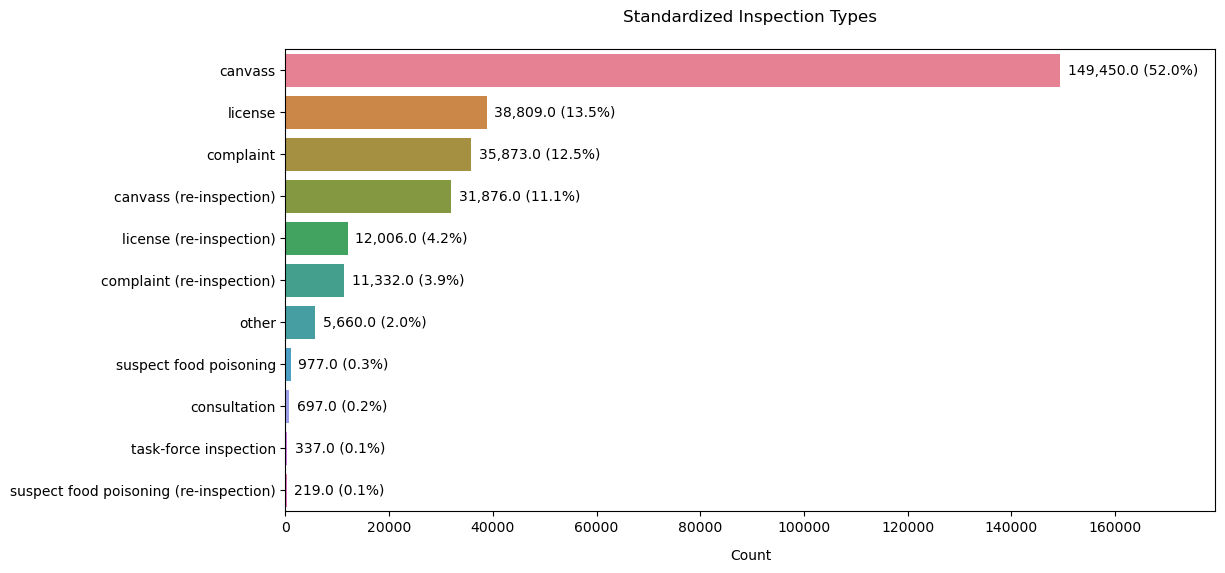

In [68]:
print("\n=== INSPECTION TYPE PROFILE ===")
profile_inspection_type(updated_food_dataset)

#### 8. Profiling Results

In [69]:
# profiling results
def profile_results(df):
    """
    Profiles the results column with outcome analysis
    using a 7-color palette optimized for readability.
    """
    # Clean and standardize results
    df = df.copy()  # Avoid modifying original DataFrame
    df['results'] = df['results'].str.strip().str.title()
    
    # Calculate distribution
    result_counts = df['results'].value_counts()
    result_pct = (df['results'].value_counts(normalize=True) * 100).round(1)
    
    # Visualization with Set2 palette
    plt.figure(figsize=(10, 6))
    
    # Get 7 colors from Set2 palette
    palette = sns.color_palette("Set2", 7)
    
    # Create ordered list of results (pass-like outcomes first)
    ordered_results = sorted(
        result_counts.index,
        key=lambda x: (
            0 if 'Pass' in x else 
            1 if 'Fail' in x else 
            2 if 'Condition' in x else 3
        )
    )
    
    # Plot with corrected syntax
    ax = sns.barplot(
        x=result_counts.loc[ordered_results].values,
        y=ordered_results,
        palette=palette,
        hue=ordered_results if len(ordered_results) > 1 else None,
        legend=False,
        dodge=False
    )
    
    # Add value labels
    for p in ax.patches:
        width = p.get_width()
        ax.text(
            width + max(result_counts)*0.01,
            p.get_y() + p.get_height()/2,
            f'{width:,} ({result_pct[ordered_results[int(p.get_y() + 0.5)]]}%)',
            va='center',
            fontsize=10
        )
    
    plt.title('Inspection Outcomes Distribution', pad=20)
    plt.xlabel('Count', labelpad=10)
    plt.ylabel('Result', labelpad=10)
    plt.xlim(0, max(result_counts)*1.15)
    
    # Print key stats
    print("\nOutcome Distribution Summary:")
    print("="*40)
    for result in ordered_results:
        print(f"• {result:<20}: {result_counts[result]:>8,} ({result_pct[result]}%)")
    print("="*40)


=== RESULTS PROFILE ===

Outcome Distribution Summary:
• Pass                :  148,027 (51.5%)
• Pass W/ Conditions  :   43,357 (15.1%)
• Fail                :   55,771 (19.4%)
• Out Of Business     :   24,078 (8.4%)
• No Entry            :   12,112 (4.2%)
• Not Ready           :    3,800 (1.3%)
• Business Not Located:       92 (0.0%)


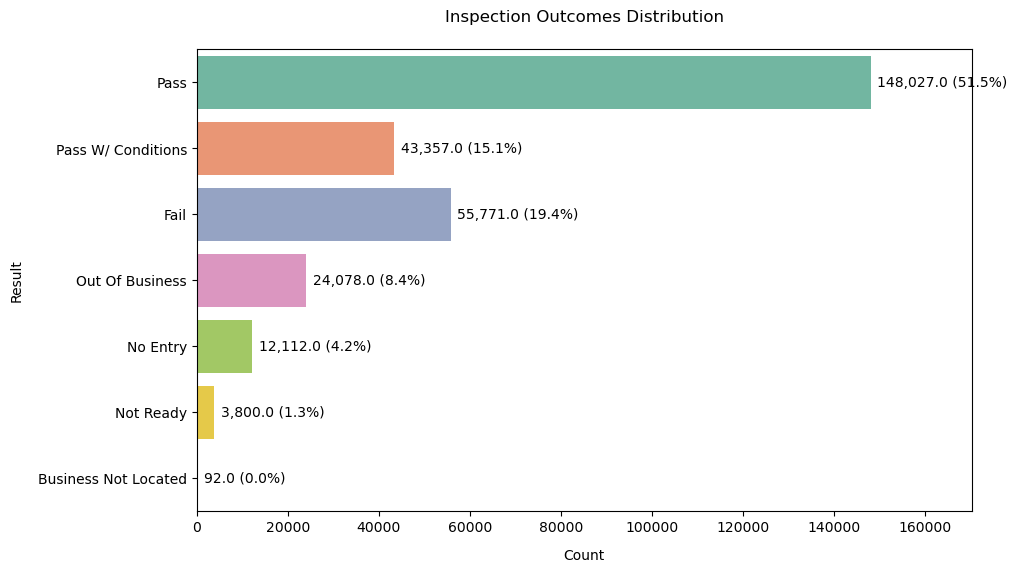

In [70]:
print("\n=== RESULTS PROFILE ===")
profile_results(updated_food_dataset)